## 第二部分：职业足球比赛的进球数规律
作者：带球小弟

### 数据来源

* [欧洲足球数据库](https://www.kaggle.com/hugomathien/soccer)

### 主要发现
* 欧洲职业足球比赛确实有主场优势。主队获胜占46%，双方打平占25%，客队获胜占29%。
* 欧洲职业足球比赛场均进球数为2.71个，主队场均进球数为1.54个，客队场均进球数为1.16个。
* 最常见的比分是1:1，其次是1:0，然后是2:1和2:0（区分主客队，主队在前，客队在后。比如，1:0代表主队1:0客队，0:1代表主队0:1客队）。
* 足球比赛进球数服从泊松分布。利用泊松分布和场均进球数可以预估足球比赛的一些总体情况，包括进球数分布、比分分布和比赛结果分布。
* 前面三个发现只针对于欧洲职业足球比赛，不一定适用于其他情况。第四个泊松分布普遍适用于所有足球比赛。

### 详细内容
#### 1. [欧洲主要联赛进球数的比较](#1)
#### 2. [与进球数相关的Top 10系列](#2)
#### 3. [泊松分布](#3)

#### 数据分析详细过程

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sqlite3
from scipy.stats import poisson  # 泊松分布
from scipy.stats import skellam  # skellam分布
import pickle
from tqdm import tqdm
import os

sns.set_style('whitegrid')
sns.set_context('poster')

print('所有需要的python模块都已导入。')

所有需要的python模块都已导入。


连接数据库

In [2]:
# 与数据库建立连接

# 数据库文件名称
db_filename = 'database.sqlite'

# 根据实际情况修改数据库文件路径
db_filedir = os.path.join(os.path.pardir, os.path.pardir, os.path.pardir, 'data_source', 'kaggle', db_filename)

try:
    con=sqlite3.connect(db_filedir)
    print('成功与数据库建立连接。\n')
except Exception as e:
    print('无法与数据库建立连接。')

cursor=con.execute("select name from sqlite_master where type='table'")
print('在数据库中找到了以下数据表：')
for i in cursor.fetchall():
    print('{}'.format(i[0]))

成功与数据库建立连接。

在数据库中找到了以下数据表：
sqlite_sequence
Player_Attributes
Player
Match
League
Country
Team
Team_Attributes


解释：
* sqlite_sequence: 与数据库自身相关信息
* Player_Attributes：球员属性
* Player：球员信息
* Match：比赛信息
* League：联赛信息
* Country：国家信息
* Team：球队信息
* Team_Attributes：球队属性

In [3]:
# 读取球员信息数据表
try:
    player = pd.read_sql_query('select * from Player',con)
    print('成功导入球员信息数据表。')
except Exception as e:
    print('无法导入球员信息数据表。')

# 读取比赛信息数据表
try:
    match = pd.read_sql_query('select * from Match',con)
    print('成功导入比赛信息数据表。')
except Exception as e:
    print('无法导入比赛信息数据表。')
    
# 读取联赛信息数据表
try:
    league=pd.read_sql_query('select * from League',con)
    print('成功导入联赛信息数据表。')
except Exception as e:
    print('无法导入联赛信息数据表。')

# 读取国家信息数据表
try:
    country=pd.read_sql_query('select * from Country',con)
    print('成功导入国家信息数据表。')
except Exception as e:
    print('无法导入国家信息数据表。')

# 读取球队信息数据表
try:
    team=pd.read_sql_query('select * from Team', con)
    print('成功导入球队信息数据表。')
except Exception as e:
    print('无法导入球队信息数据表。')

成功导入球员信息数据表。
成功导入比赛信息数据表。
成功导入联赛信息数据表。
成功导入国家信息数据表。
成功导入球队信息数据表。


下面重点看一下比赛信息数据表里有什么内容。

In [4]:
print('比赛数据表一共有{}列。 每一列代表的是： \n\n{}\n'.format(match.shape[1], match.columns.values))
print(match.info())
print('\n数据表的最开头两行内容如下：')
match.head(2)

比赛数据表一共有115列。 每一列代表的是： 

['id' 'country_id' 'league_id' 'season' 'stage' 'date' 'match_api_id'
 'home_team_api_id' 'away_team_api_id' 'home_team_goal' 'away_team_goal'
 'home_player_X1' 'home_player_X2' 'home_player_X3' 'home_player_X4'
 'home_player_X5' 'home_player_X6' 'home_player_X7' 'home_player_X8'
 'home_player_X9' 'home_player_X10' 'home_player_X11' 'away_player_X1'
 'away_player_X2' 'away_player_X3' 'away_player_X4' 'away_player_X5'
 'away_player_X6' 'away_player_X7' 'away_player_X8' 'away_player_X9'
 'away_player_X10' 'away_player_X11' 'home_player_Y1' 'home_player_Y2'
 'home_player_Y3' 'home_player_Y4' 'home_player_Y5' 'home_player_Y6'
 'home_player_Y7' 'home_player_Y8' 'home_player_Y9' 'home_player_Y10'
 'home_player_Y11' 'away_player_Y1' 'away_player_Y2' 'away_player_Y3'
 'away_player_Y4' 'away_player_Y5' 'away_player_Y6' 'away_player_Y7'
 'away_player_Y8' 'away_player_Y9' 'away_player_Y10' 'away_player_Y11'
 'home_player_1' 'home_player_2' 'home_player_3' 'home_player_4'


,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,SJA,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.0,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.2
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.8,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.6


解释：
* id：比赛记录ID
* country_id：比赛所在国家ID
* league_id：比赛所在联赛ID
* season：比赛所在的赛季
* stage：比赛所在的轮数
* date：比赛日期
* match_api_id：比赛ID
* home_team_api_id：主队ID
* away_team_api_id：客队ID
* home_team_goal：主队进球数
* away_team_goal：客队进球数
* home_player_X1：不明
* goal：进球事件详细记录（以xml形式保存，下面类似数据解释相同）
* shoton：射正
* shotoff：射偏
* foulcommit：犯规
* card：红黄牌
* cross：传中
* corner：角球
* possession：控球率
* B365H：B365主队获胜赔率（其他博彩公司赔率解释相同）
* B365D：B365双方打平赔率
* B365A：B365客队获胜赔率

下面把可读信息加入比赛数据表，对ID信息进行解读。

加入国家名字 

In [5]:
# 把国家信息数据表的表头名字改成和比赛数据表相应栏一致，这样方便把国家名字加入到比赛信息数据表中
country.columns = ['country_id', 'country']

# 把国家名字加入比赛信息表中
match = pd.merge(match, country, on='country_id', how='left')
print('成功把国家信息合并到比赛信息表中。\n')
print('合并后的表中最开头三行内容如下：')
match.head(3)

成功把国家信息合并到比赛信息表中。

合并后的表中最开头三行内容如下：


,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,VCH,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA,country
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,1.65,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20,Belgium
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,2.00,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60,Belgium
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.35,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75,Belgium


加入联赛名字

In [6]:
# 把联赛信息数据表的表头名字改成和比赛数据表相应栏一致，这样方便把联赛名字加入到比赛信息数据表中
league.columns = ['league_id', 'country_id','league']

# 把联赛名字加入比赛信息表中
match = pd.merge(match, league[['league_id','league']], on='league_id', how='left')
print('成功把联赛信息合并到比赛信息表中。\n')
print('合并后的表中最开头三行内容如下：')
match.head(3)

成功把联赛信息合并到比赛信息表中。

合并后的表中最开头三行内容如下：


,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,VCD,VCA,GBH,GBD,GBA,BSH,BSD,BSA,country,league
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,3.40,4.50,1.78,3.25,4.00,1.73,3.40,4.20,Belgium,Belgium Jupiler League
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.25,3.25,1.85,3.25,3.75,1.91,3.25,3.60,Belgium,Belgium Jupiler League
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,3.25,2.65,2.50,3.20,2.50,2.30,3.20,2.75,Belgium,Belgium Jupiler League


加入主队名称

In [7]:
# 对球队信息数据表进行复制，生成主队信息数据表
home_team = team

# 把主队信息数据表的表头名字改成和比赛数据表相应栏一致，这样方便把主队名字加入到比赛信息数据表中
home_team.columns = ['id','home_team_api_id','home_team_fifa_api_id','home_team','home_team_short_name']

# 把主队名字加入比赛信息表中
match = pd.merge(match, home_team[['home_team_api_id','home_team']], on='home_team_api_id', how='left')
print('成功把主队信息合并到比赛信息表中。\n')
print('合并后的表中最开头三行内容如下：')
match.head(3)

成功把主队信息合并到比赛信息表中。

合并后的表中最开头三行内容如下：


,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,VCA,GBH,GBD,GBA,BSH,BSD,BSA,country,league,home_team
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,4.50,1.78,3.25,4.00,1.73,3.40,4.20,Belgium,Belgium Jupiler League,KRC Genk
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,3.25,1.85,3.25,3.75,1.91,3.25,3.60,Belgium,Belgium Jupiler League,SV Zulte-Waregem
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.65,2.50,3.20,2.50,2.30,3.20,2.75,Belgium,Belgium Jupiler League,KSV Cercle Brugge


加入客队名称

In [8]:
# 对球队信息数据表进行复制，生成客队信息数据表
away_team = team

# 把客队信息数据表的表头名字改成和比赛数据表相应栏一致，这样方便把客队名字加入到比赛信息数据表中
away_team.columns = ['id','away_team_api_id','away_team_fifa_api_id','away_team','away_team_short_name']

# 把客队名字加入比赛信息表中
match = pd.merge(match, away_team[['away_team_api_id','away_team']], on='away_team_api_id', how='left')
print('成功把客队信息合并到比赛信息表中。\n')
print('合并后的表中最开头三行内容如下：')
match.head(3)

成功把客队信息合并到比赛信息表中。

合并后的表中最开头三行内容如下：


,id,country_id,league_id,season,stage,date,match_api_id,home_team_api_id,away_team_api_id,home_team_goal,...,GBH,GBD,GBA,BSH,BSD,BSA,country,league,home_team,away_team
0,1,1,1,2008/2009,1,2008-08-17 00:00:00,492473,9987,9993,1,...,1.78,3.25,4.00,1.73,3.40,4.20,Belgium,Belgium Jupiler League,KRC Genk,Beerschot AC
1,2,1,1,2008/2009,1,2008-08-16 00:00:00,492474,10000,9994,0,...,1.85,3.25,3.75,1.91,3.25,3.60,Belgium,Belgium Jupiler League,SV Zulte-Waregem,Sporting Lokeren
2,3,1,1,2008/2009,1,2008-08-16 00:00:00,492475,9984,8635,0,...,2.50,3.20,2.50,2.30,3.20,2.75,Belgium,Belgium Jupiler League,KSV Cercle Brugge,RSC Anderlecht


接下来选择需要的数据列，包括国家、联赛、赛季、轮数、比赛日期、主队、客队、主队进球数和客队进球数。然后新建两列：主队与客队之间的净胜球，以及两队的总进球数。

In [9]:
# 选择需要的数据列
selected_columns=['country', 'league', 'season', 'stage', 'date', 'home_team', 'away_team', 
                  'home_team_goal', 'away_team_goal']

match_goal = match[selected_columns]

for col in ['home_team_goal', 'away_team_goal']:
    match_goal = match_goal[match_goal[col].notnull()]

# 生成主队与客队之间的净胜球
match_goal['home_team_gd']=match_goal['home_team_goal']-match_goal['away_team_goal']

# 生成两队的总进球数
match_goal['total_goal']=match_goal['home_team_goal'] + match_goal['away_team_goal']

In [10]:
match_goal.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25979 entries, 0 to 25978
Data columns (total 11 columns):
country           25979 non-null object
league            25979 non-null object
season            25979 non-null object
stage             25979 non-null int64
date              25979 non-null object
home_team         25979 non-null object
away_team         25979 non-null object
home_team_goal    25979 non-null int64
away_team_goal    25979 non-null int64
home_team_gd      25979 non-null int64
total_goal        25979 non-null int64
dtypes: int64(5), object(6)
memory usage: 2.4+ MB


可以看到，这一数据库包含了25979场比赛。

#### <a id='1'></a>1. 欧洲主要联赛进球数的比较

#### 比赛进球数

In [12]:
print('各个联赛的场均进球数的统计如下：')
match_goal[['league','home_team_goal','away_team_goal','total_goal','home_team_gd']].groupby('league', as_index=False).mean()

各个联赛的场均进球数的统计如下：


,league,home_team_goal,away_team_goal,total_goal,home_team_gd
0,Belgium Jupiler League,1.609375,1.192130,2.801505,0.417245
1,England Premier League,1.550987,1.159539,2.710526,0.391447
2,France Ligue 1,1.402961,1.040132,2.443092,0.362829
3,Germany 1. Bundesliga,1.626634,1.274918,2.901552,0.351716
4,Italy Serie A,1.500829,1.116009,2.616838,0.384819
5,Netherlands Eredivisie,1.779820,1.301062,3.080882,0.478758
6,Poland Ekstraklasa,1.394792,1.030208,2.425000,0.364583
7,Portugal Liga ZON Sagres,1.408382,1.126218,2.534600,0.282164
8,Scotland Premier League,1.429276,1.204496,2.633772,0.224781
9,Spain LIGA BBVA,1.631250,1.135855,2.767105,0.495395


下面对这一统计进行数据可视化分析。

#### 主队场均进球数

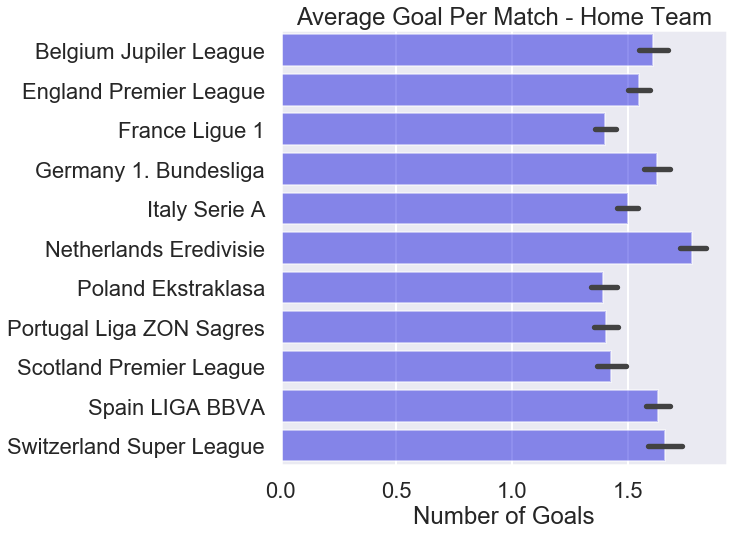

In [30]:
plt.figure(figsize=(8,8))
ax=sns.barplot(y="league", x="home_team_goal", color='b',alpha=0.5,data=match_goal)
plt.ylabel('')
plt.xlabel('Number of Goals')
plt.title('Average Goal Per Match - Home Team')

荷甲的主队场均进球数最高，达到了1.78球。葡超和法甲的主队场均进球数最低，为1.4球。

#### 客队场均进球数

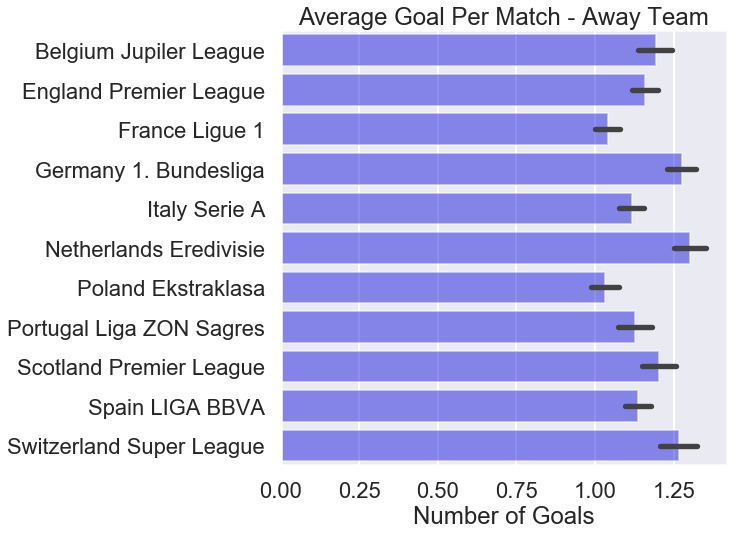

In [31]:
plt.figure(figsize=(8,8))
ax=sns.barplot(y="league", x="away_team_goal", color='b',alpha=0.5, data=match_goal)
plt.ylabel('')
plt.xlabel('Number of Goals')
plt.title('Average Goal Per Match - Away Team')

荷甲联赛的客队场均进球数也是最高的，达到了1.30球。波兰联赛的客队场均进球数最低，为1.03球。 

#### 场均总进球数 

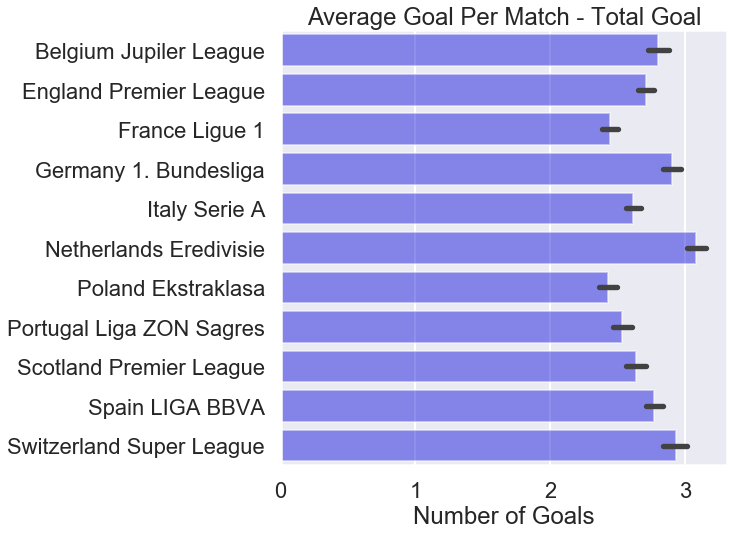

In [32]:
plt.figure(figsize=(8,8))
ax=sns.barplot(y="league", x="total_goal", color='b',alpha=0.5, data=match_goal)
plt.ylabel('')
plt.xlabel('Number of Goals')
plt.title('Average Goal Per Match - Total Goal')

荷甲的场均总进球数最多，达到了3.08球。波兰联赛的场均进球数最低，为2.43球。

#### 主队与客队之间的场均净胜球

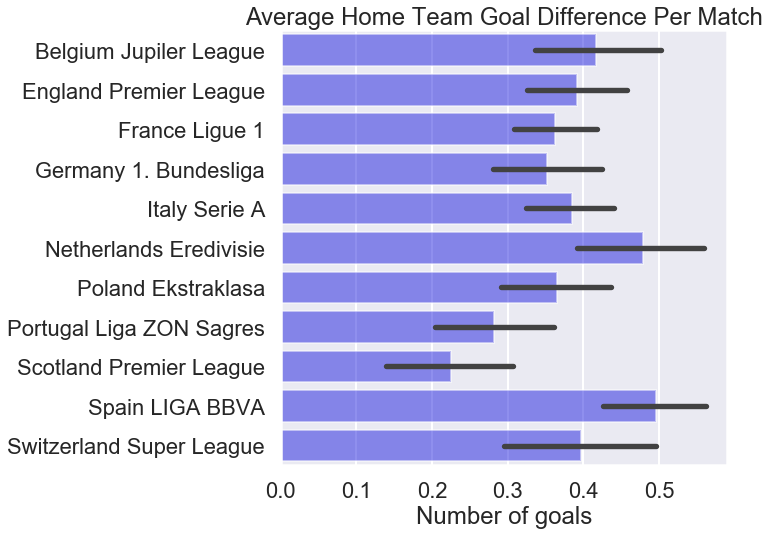

In [33]:
plt.figure(figsize=(8,8))
ax=sns.barplot(y="league", x="home_team_gd", color='b',alpha=0.5, data=match_goal)
plt.ylabel('')
plt.xlabel('Number of goals')
plt.title('Average Home Team Goal Difference Per Match')

* 在所有11个欧洲职业足球联赛中，主队的场均进球数都要比客队多。这表明欧洲职业足球比赛确实有主场优势。
* 西甲的主场优势最为明显，主队场均净胜球达到了0.5个。
* 苏格兰超级联赛的场均净胜球最少，为0.22个。

#### 2. <a id='2'></a>与进球数相关的Top 10系列
#### 10大主队进球最多的比赛

In [34]:
n_top = 10
match_goal.sort_values('home_team_goal',ascending=False).head(n_top)

,country,league,season,stage,date,home_team,away_team,home_team_goal,away_team_goal,home_team_gd,total_goal
24247,Spain,Spain LIGA BBVA,2015/2016,16,2015-12-20 00:00:00,Real Madrid CF,Rayo Vallecano,10,2,8,12
13898,Netherlands,Netherlands Eredivisie,2010/2011,10,2010-10-24 00:00:00,PSV,Feyenoord,10,0,10,10
24015,Spain,Spain LIGA BBVA,2014/2015,29,2015-04-05 00:00:00,Real Madrid CF,Granada CF,9,1,8,10
2156,England,England Premier League,2009/2010,13,2009-11-22 00:00:00,Tottenham Hotspur,Wigan Athletic,9,1,8,10
9210,Germany,Germany 1. Bundesliga,2012/2013,27,2013-03-30 00:00:00,FC Bayern Munich,Hamburger SV,9,2,7,11
20161,Scotland,Scotland Premier League,2010/2011,11,2010-11-06 00:00:00,Celtic,Aberdeen,9,0,9,9
4375,England,England Premier League,2014/2015,8,2014-10-18 00:00:00,Southampton,Sunderland,8,0,8,8
3338,England,England Premier League,2012/2013,18,2012-12-23 00:00:00,Chelsea,Aston Villa,8,0,8,8
22587,Spain,Spain LIGA BBVA,2010/2011,38,2011-05-21 00:00:00,Real Madrid CF,UD Almería,8,1,7,9
21337,Scotland,Scotland Premier League,2015/2016,17,2016-01-19 00:00:00,Celtic,Hamilton Academical FC,8,1,7,9


并列排在第一位的是皇马10:2巴列卡诺（2015/2016赛季的西甲联赛），和埃因霍温10:0费耶诺德（2010/2011赛季的荷甲联赛）。

#### 10大客队进球最多的比赛

In [35]:
n_top = 10
match_goal.sort_values('away_team_goal',ascending=False).head(n_top)

,country,league,season,stage,date,home_team,away_team,home_team_goal,away_team_goal,home_team_gd,total_goal
7660,France,France Ligue 1,2015/2016,30,2016-03-13 00:00:00,ES Troyes AC,Paris Saint-Germain,0,9,-9,9
22310,Spain,Spain LIGA BBVA,2010/2011,12,2010-11-20 00:00:00,UD Almería,FC Barcelona,0,8,-8,8
24450,Spain,Spain LIGA BBVA,2015/2016,34,2016-04-20 00:00:00,RC Deportivo de La Coruña,FC Barcelona,0,8,-8,8
8662,Germany,Germany 1. Bundesliga,2010/2011,33,2011-05-07 00:00:00,FC St. Pauli,FC Bayern Munich,1,8,-7,9
24122,Spain,Spain LIGA BBVA,2014/2015,4,2014-09-20 00:00:00,RC Deportivo de La Coruña,Real Madrid CF,2,8,-6,10
24081,Spain,Spain LIGA BBVA,2014/2015,35,2015-05-02 00:00:00,Córdoba CF,FC Barcelona,0,8,-8,8
24736,Switzerland,Switzerland Super League,2008/2009,9,2008-09-14 00:00:00,FC Vaduz,FC Zürich,1,7,-6,8
11214,Italy,Italy Serie A,2010/2011,27,2011-02-27 00:00:00,Palermo,Udinese,0,7,-7,7
25901,Switzerland,Switzerland Super League,2015/2016,28,2016-04-17 00:00:00,FC St. Gallen,FC Basel,0,7,-7,7
24765,Switzerland,Switzerland Super League,2009/2010,14,2009-10-29 00:00:00,AC Bellinzona,BSC Young Boys,1,7,-6,8


排在第一位的是特鲁瓦0:9巴黎圣日耳曼（2015/2016赛季法甲联赛）。

#### 10大主队净胜球最多的比赛

In [36]:
n_top = 10
match_goal.sort_values('home_team_gd',ascending=False).head(n_top)

,country,league,season,stage,date,home_team,away_team,home_team_goal,away_team_goal,home_team_gd,total_goal
13898,Netherlands,Netherlands Eredivisie,2010/2011,10,2010-10-24 00:00:00,PSV,Feyenoord,10,0,10,10
20161,Scotland,Scotland Premier League,2010/2011,11,2010-11-06 00:00:00,Celtic,Aberdeen,9,0,9,9
2156,England,England Premier League,2009/2010,13,2009-11-22 00:00:00,Tottenham Hotspur,Wigan Athletic,9,1,8,10
24247,Spain,Spain LIGA BBVA,2015/2016,16,2015-12-20 00:00:00,Real Madrid CF,Rayo Vallecano,10,2,8,12
22984,Spain,Spain LIGA BBVA,2011/2012,4,2011-09-17 00:00:00,FC Barcelona,CA Osasuna,8,0,8,8
9761,Germany,Germany 1. Bundesliga,2014/2015,21,2015-02-14 00:00:00,FC Bayern Munich,Hamburger SV,8,0,8,8
3338,England,England Premier League,2012/2013,18,2012-12-23 00:00:00,Chelsea,Aston Villa,8,0,8,8
24015,Spain,Spain LIGA BBVA,2014/2015,29,2015-04-05 00:00:00,Real Madrid CF,Granada CF,9,1,8,10
2420,England,England Premier League,2009/2010,38,2010-05-09 00:00:00,Chelsea,Wigan Athletic,8,0,8,8
4375,England,England Premier League,2014/2015,8,2014-10-18 00:00:00,Southampton,Sunderland,8,0,8,8


排在第一位的是埃因霍温10:0费耶诺德（2010/2011赛季的荷甲联赛）。

#### 10大客队净胜球最多的比赛

In [37]:
n_top = 10
match_goal.sort_values('home_team_gd').head(n_top)

,country,league,season,stage,date,home_team,away_team,home_team_goal,away_team_goal,home_team_gd,total_goal
7660,France,France Ligue 1,2015/2016,30,2016-03-13 00:00:00,ES Troyes AC,Paris Saint-Germain,0,9,-9,9
24450,Spain,Spain LIGA BBVA,2015/2016,34,2016-04-20 00:00:00,RC Deportivo de La Coruña,FC Barcelona,0,8,-8,8
22310,Spain,Spain LIGA BBVA,2010/2011,12,2010-11-20 00:00:00,UD Almería,FC Barcelona,0,8,-8,8
24081,Spain,Spain LIGA BBVA,2014/2015,35,2015-05-02 00:00:00,Córdoba CF,FC Barcelona,0,8,-8,8
11214,Italy,Italy Serie A,2010/2011,27,2011-02-27 00:00:00,Palermo,Udinese,0,7,-7,7
25901,Switzerland,Switzerland Super League,2015/2016,28,2016-04-17 00:00:00,FC St. Gallen,FC Basel,0,7,-7,7
22949,Spain,Spain LIGA BBVA,2011/2012,36,2012-04-29 00:00:00,Rayo Vallecano,FC Barcelona,0,7,-7,7
9395,Germany,Germany 1. Bundesliga,2013/2014,15,2013-12-07 00:00:00,SV Werder Bremen,FC Bayern Munich,0,7,-7,7
12463,Italy,Italy Serie A,2013/2014,4,2013-09-22 00:00:00,Sassuolo,Inter,0,7,-7,7
8662,Germany,Germany 1. Bundesliga,2010/2011,33,2011-05-07 00:00:00,FC St. Pauli,FC Bayern Munich,1,8,-7,9


排在第一位的是特鲁瓦0:9巴黎圣日耳曼（2015/2016赛季法甲联赛）。

#### 10大总进球数最多的比赛

In [38]:
n_top = 10
match_goal.sort_values('total_goal',ascending=False).head(n_top)

,country,league,season,stage,date,home_team,away_team,home_team_goal,away_team_goal,home_team_gd,total_goal
20106,Scotland,Scotland Premier League,2009/2010,37,2010-05-05 00:00:00,Motherwell,Hibernian,6,6,0,12
24247,Spain,Spain LIGA BBVA,2015/2016,16,2015-12-20 00:00:00,Real Madrid CF,Rayo Vallecano,10,2,8,12
9210,Germany,Germany 1. Bundesliga,2012/2013,27,2013-03-30 00:00:00,FC Bayern Munich,Hamburger SV,9,2,7,11
3092,England,England Premier League,2011/2012,3,2011-08-28 00:00:00,Manchester United,Arsenal,8,2,6,10
3368,England,England Premier League,2012/2013,20,2012-12-29 00:00:00,Arsenal,Newcastle United,7,3,4,10
23443,Spain,Spain LIGA BBVA,2013/2014,11,2013-10-30 00:00:00,Real Madrid CF,Sevilla FC,7,3,4,10
13898,Netherlands,Netherlands Eredivisie,2010/2011,10,2010-10-24 00:00:00,PSV,Feyenoord,10,0,10,10
24015,Spain,Spain LIGA BBVA,2014/2015,29,2015-04-05 00:00:00,Real Madrid CF,Granada CF,9,1,8,10
24113,Spain,Spain LIGA BBVA,2014/2015,38,2015-05-23 00:00:00,Real Madrid CF,Getafe CF,7,3,4,10
24122,Spain,Spain LIGA BBVA,2014/2015,4,2014-09-20 00:00:00,RC Deportivo de La Coruña,Real Madrid CF,2,8,-6,10


并列排在第一位的是：马瑟韦尔6:6希伯尼安（2009/2010苏格兰超级联赛）和皇马10:2巴列卡诺（2015/2016赛季的西甲联赛）。

#### 主队和客队进球数都超过4个（不包含4个）的比赛

In [39]:
match_goal[(match_goal['home_team_goal']>4)&(match_goal['away_team_goal']>4)]

,country,league,season,stage,date,home_team,away_team,home_team_goal,away_team_goal,home_team_gd,total_goal
3565,England,England Premier League,2012/2013,38,2013-05-19 00:00:00,West Bromwich Albion,Manchester United,5,5,0,10
5191,France,France Ligue 1,2009/2010,13,2009-11-08 00:00:00,Olympique Lyonnais,Olympique de Marseille,5,5,0,10
20106,Scotland,Scotland Premier League,2009/2010,37,2010-05-05 00:00:00,Motherwell,Hibernian,6,6,0,12


一共有三场：西布朗维奇5:5曼联（2012/2013赛季英格兰超级联赛），里昂5:5马赛（2009/2010赛季法甲联赛）和马瑟韦尔6:6希伯尼安（2009/2010苏格兰超级联赛）。

#### 10大进攻最强的主队

In [40]:
# Average home team goal stats
home_avg_goal = match_goal[['home_team','home_team_goal','away_team_goal','total_goal','home_team_gd']].groupby('home_team',as_index=False).mean()

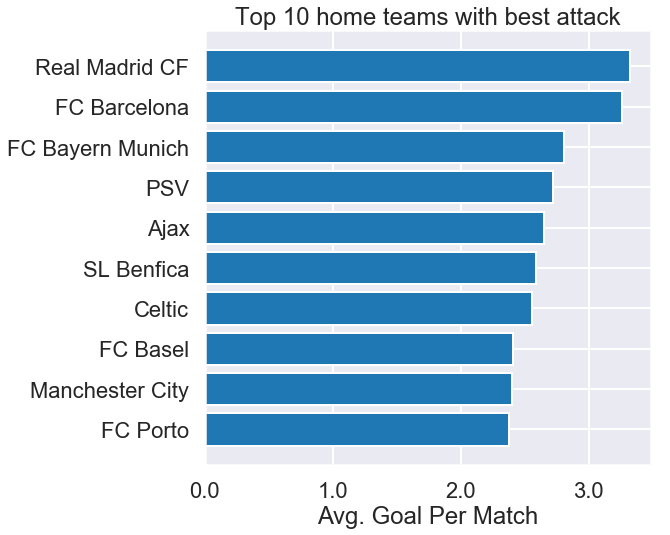

In [48]:
# Top counts number
n_top = 10

# get top counts name table
top_home_team_attack = home_avg_goal.sort_values('home_team_goal',ascending=False)[['home_team', 'home_team_goal']].head(n_top)

# Make a barhplot
fig, ax = plt.subplots(figsize=(8,8))

ax.barh(np.arange(n_top), top_home_team_attack['home_team_goal'].values, align = 'center')

# Set x&y label, ticklabel and their size
ax.set_yticks(np.arange(n_top))
ax.set_yticklabels(top_home_team_attack['home_team'].values)
ax.invert_yaxis()
ax.set_xticklabels(ax.get_xticks())
ax.set_xlabel('Avg. Goal Per Match')
ax.set_title('Top {} home teams with best attack'.format(n_top))

进攻能力最强的主队前三名：皇马，巴萨和拜仁。

#### 10大防守最强的主队

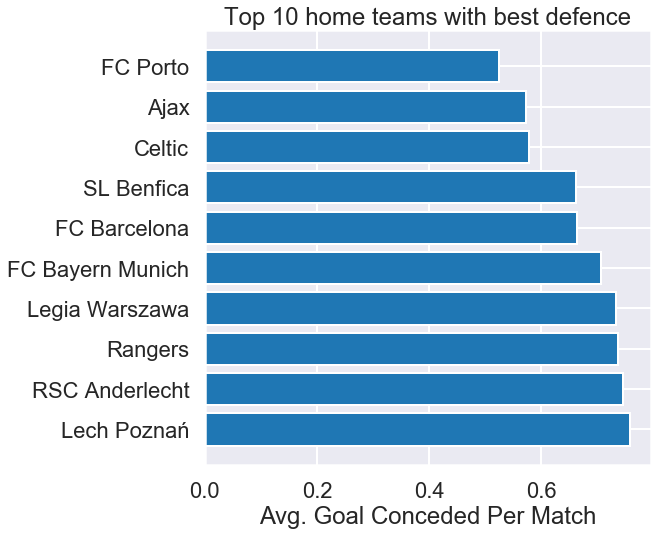

In [49]:
# Top counts number
n_top = 10

# get top counts name table
top_home_team_defence = home_avg_goal.sort_values('away_team_goal')[['home_team', 'away_team_goal']].head(n_top)

# Make a barhplot
fig, ax = plt.subplots(figsize=(8,8))

ax.barh(np.arange(n_top), top_home_team_defence['away_team_goal'].values, align = 'center')

# Set x&y label, ticklabel and their size
ax.set_yticks(np.arange(n_top))
ax.set_yticklabels(top_home_team_defence['home_team'].values)
ax.invert_yaxis()
ax.set_xticklabels(ax.get_xticks())
ax.set_xlabel('Avg. Goal Conceded Per Match')
ax.set_title('Top {} home teams with best defence'.format(n_top))

防守最强的主队前三名为：波尔图，阿贾克斯和凯尔特人。

#### 10大进攻最强的客队

In [51]:
# Average away team stats
away_avg_goal = match_goal[['away_team','home_team_goal','away_team_goal','total_goal','home_team_gd']].groupby('away_team',as_index=False).mean()

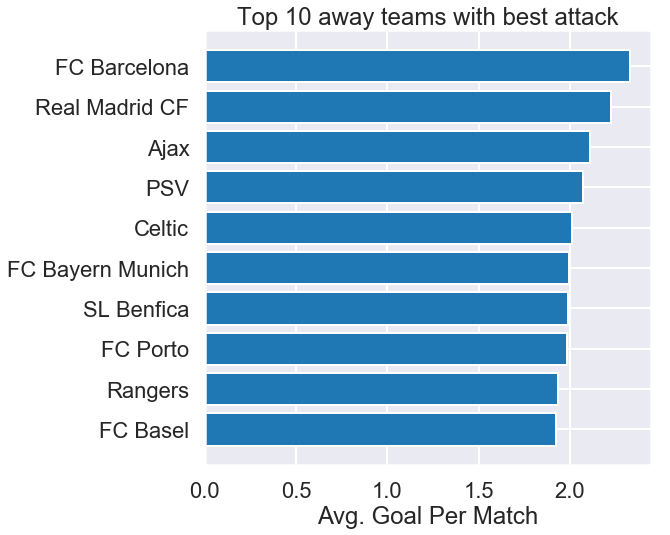

In [52]:
# Top counts number
n_top = 10

# get top counts name table
top_away_team_attack = away_avg_goal.sort_values('away_team_goal',ascending=False)[['away_team', 'away_team_goal']].head(n_top)

# Make a barhplot
fig, ax = plt.subplots(figsize=(8,8))

ax.barh(np.arange(n_top), top_away_team_attack['away_team_goal'].values, align = 'center')

# Set x&y label, ticklabel and their size
ax.set_yticks(np.arange(n_top))
ax.set_yticklabels(top_away_team_attack['away_team'].values)
ax.invert_yaxis()
ax.set_xticklabels(ax.get_xticks())
ax.set_xlabel('Avg. Goal Per Match')
ax.set_title('Top {} away teams with best attack'.format(n_top))

进攻最强的客队前三名是：皇马，巴萨和阿贾克斯。

#### 10大防守最强的客队

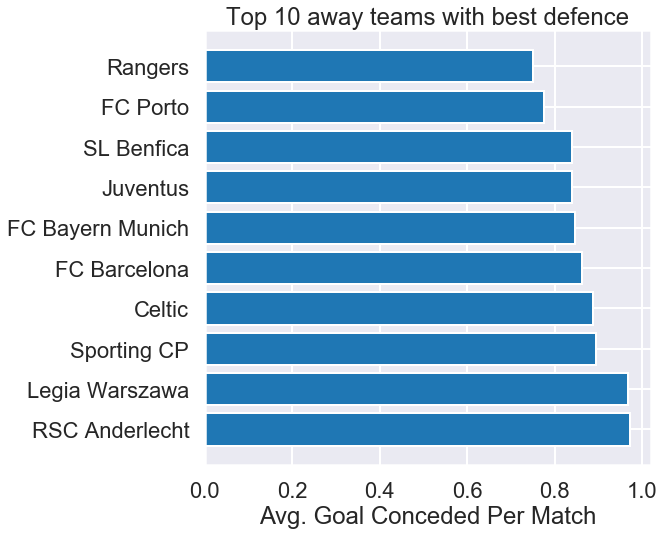

In [54]:
# Top counts number
n_top = 10

# get top counts name table
top_away_team_defence = away_avg_goal.sort_values('home_team_goal')[['away_team', 'home_team_goal']].head(n_top)

# Make a barhplot
fig, ax = plt.subplots(figsize=(8,8))

ax.barh(np.arange(n_top), top_away_team_defence['home_team_goal'].values, align = 'center')

# Set x&y label, ticklabel and their size
ax.set_yticks(np.arange(n_top))
ax.set_yticklabels(top_away_team_defence['away_team'].values)
ax.invert_yaxis()
ax.set_xticklabels(ax.get_xticks())
ax.set_xlabel('Avg. Goal Conceded Per Match')
ax.set_title('Top {} away teams with best defence'.format(n_top))

防守最强的客队前三名是：格拉斯哥流浪者，波尔图和本菲卡。

#### <a id='3'></a>3. 泊松分布
泊松分布表示如下：$$P(X = k) = \frac{\lambda^ke^{-\lambda}}{k!}, k = 0,1,2,...$$

其中$\lambda$为事件出现的期望值。

步骤
1. 利用泊松分布模型对足球比赛的进球数数据进行拟合，得到对$\lambda$的估计。事实上，这一过程相当简单，因为由概率论与数理统计的知识可以知道，对$\lambda$的估计就是场均进球数。所以第一步就是计算场均进球数。
2. 利用泊松分布模型和场均进球数，计算出进球数的理论计算分布。
3. 比较实际数据与理论计算分布，如果非常接近，就说明足球比赛的进球数分布服从泊松分布。

#### 主队进球数分布

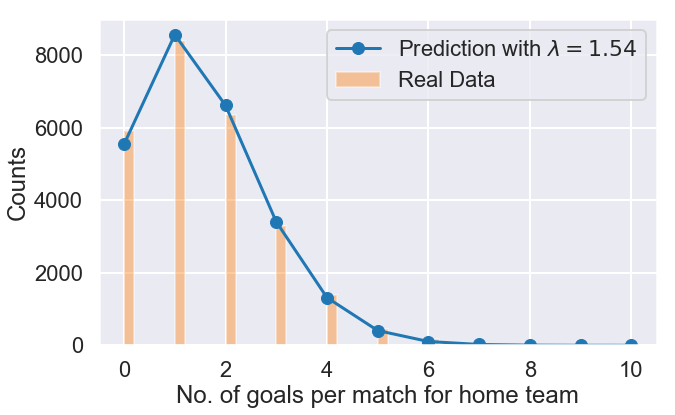

In [74]:
# Estimate lambda for home team goal
lambda_home = match_goal['home_team_goal'].mean()

plt.figure(figsize=(10,6))
plt.plot(np.arange(11), poisson.pmf(np.arange(11), lambda_home)*match_goal.shape[0], '-o', label="Prediction with $\lambda = %.2f$"%lambda_home)
ax=sns.distplot(match_goal['home_team_goal'],kde=False, label='Real Data')
plt.xlabel('No. of goals per match for home team')
plt.ylabel('Counts')
plt.legend()

#### 客队进球数分布

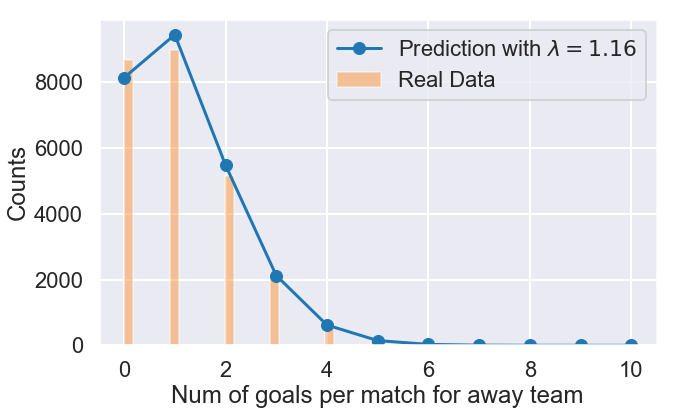

In [71]:
# Estimate lambda for home team goal
lambda_away=match_goal['away_team_goal'].mean()

plt.figure(figsize=(10,6))
plt.plot(np.arange(11), poisson.pmf(np.arange(11), lambda_away)*match_goal.shape[0], '-o', label="Prediction with $\lambda = %.2f$"%lambda_away)
ax=sns.distplot(match_goal['away_team_goal'],kde=False, label='Real Data')
plt.xlabel('Num of goals per match for away team')
plt.ylabel('Counts')
plt.legend()

从以上两个结果可以知道，足球比赛进球数确实服从泊松分布。

下面利用泊松分布进行推广计算。

#### 总进球数分布
总进球数也应该服从泊松分布。这是因为：主队进球数 ~ $P(\lambda_{home})$，客队进球数 ~ $P(\lambda_{away})$，所以总进球数 ~ $P(\lambda_{home}+\lambda_{away})$（详细推导过程请查看链接）[[1]](https://math.stackexchange.com/questions/221078/poisson-distribution-of-sum-of-two-random-independent-variables-x-y)。

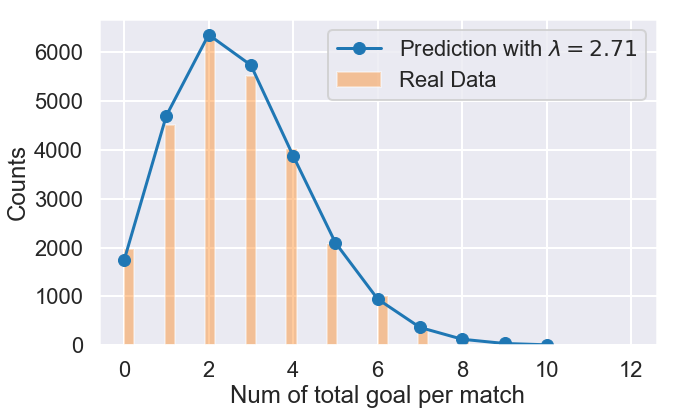

In [70]:
# Estimate lambda for total goal
lambda_total=match_goal['total_goal'].mean()

plt.figure(figsize=(10,6))
plt.plot(np.arange(11), poisson.pmf(np.arange(11), lambda_total)*match_goal.shape[0], '-o', label="Prediction with $\lambda = %.2f$"%lambda_total)
ax=sns.distplot(match_goal['total_goal'],kde=False, label='Real Data')
plt.xlabel('Num of total goal per match')
plt.ylabel('Counts')
plt.legend()
#plt.savefig('poisson_match_goal.jpg', dpi=400)

#### 主队与客队之间的净胜球分布

因为主队和客队的进球数服从泊松分布，由理论推导可知，两队的净胜球数服从Skellam分布（详细推导请参看链接[[2]](https://en.wikipedia.org/wiki/Skellam_distribution) [[3]](https://stats.stackexchange.com/questions/47749/how-to-calculate-cumulative-poisson-probabilities-without-adding-each-one-if-no)）。

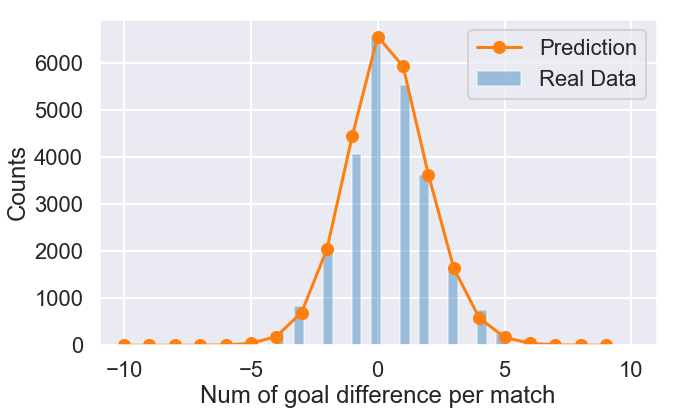

In [73]:
# define goal difference range for plot
gd_range = np.arange(20) - 10   # -10 to 9

plt.figure(figsize=(10,6))
sns.distplot(match_goal['home_team_gd'],kde=False, label='Real Data')
plt.plot(gd_range, skellam.pmf(gd_range, lambda_home, lambda_away)*match_goal.shape[0], '-o', label="Prediction")
plt.xlabel('Num of goal difference per match')
plt.ylabel('Counts')
plt.legend()

#### 比赛胜平负比例

利用泊松分布模型和场均进球数还可以预估出足球比赛胜平负的总体比例。

In [75]:
# Encode match result
# home team win:  0
# home team draw: 1
# home team lose: 2
match_goal['result'] = np.where(match_goal['home_team_gd'] > 0, 0, np.where(match_goal['home_team_gd'] < 0, 2, 1))

In [81]:
# Use Possion Distribution to predict match result percentage
p_win, p_draw, p_lose = 0, 0, 0

# Maxmium number of goals for a team per match
n_max = 20

# Loop over all possibility of home team goal
for i in np.arange(n_max):
    # Loop over all possibility of away team goal
    for j in np.arange(n_max):
        # home team win
        if i > j:
            p_win = p_win+poisson.pmf(np.arange(n_max), lambda_home)[i]*poisson.pmf(np.arange(n_max), lambda_away)[j]
        # draw
        elif i == j:
            p_draw = p_draw+poisson.pmf(np.arange(n_max), lambda_home)[i]*poisson.pmf(np.arange(n_max), lambda_away)[j]
        # home team lose
        else:
            p_lose = p_lose+poisson.pmf(np.arange(n_max), lambda_home)[i]*poisson.pmf(np.arange(n_max), lambda_away)[j]

# home team win ratio
print('主队获胜实际比例：{:.2f}%'.format(match_goal.groupby('result', as_index=False).count()['country'].values[0]/match_goal.shape[0]*100))
print('主队获胜概率估计：{:.2f}%\n'.format(p_win*100))

# draw ratio
print('双方打平实际比例：{:.2f}%'.format(match_goal.groupby('result', as_index=False).count()['country'].values[1]/match_goal.shape[0]*100))
print('双方打平概率估计：{:.2f}%\n'.format(p_draw*100))

# home team lose ratio
print('客队获胜实际比例：{:.2f}%'.format(match_goal.groupby('result', as_index=False).count()['country'].values[2]/match_goal.shape[0]*100))
print('客队获胜概率估计：{:.2f}%\n'.format(p_lose*100))

主队获胜实际比例：45.87%
主队获胜概率估计：46.16%

双方打平实际比例：25.39%
双方打平概率估计：25.24%

客队获胜实际比例：28.74%
客队获胜概率估计：28.60%



等价地，也可以利用Skellam分布得到相同的结果。

In [82]:
# Use Skellam Distribution to predict match result percentage

# n_max: range of goal difference. For example, if n_max = 3, the calcution will add up p(1), p(2) and p(3) for home team win,
# and will add up p(-1), (p-2) and p(-3) for home team lose
n_max = 20

p_win = np.sum(skellam.pmf(np.arange(n_max)+1, lambda_home, lambda_away))
p_draw = np.sum(skellam.pmf(0, lambda_home, lambda_away))
p_lose = np.sum(skellam.pmf(np.arange(n_max)-n_max, lambda_home, lambda_away))

# home team win ratio
print('主队获胜实际比例：{:.2f}%'.format(match_goal.groupby('result', as_index=False).count()['country'].values[0]/match_goal.shape[0]*100))
print('主队获胜概率估计：{:.2f}%\n'.format(p_win*100))

# draw ratio
print('双方打平实际比例：{:.2f}%'.format(match_goal.groupby('result', as_index=False).count()['country'].values[1]/match_goal.shape[0]*100))
print('双方打平概率估计：{:.2f}%\n'.format(p_draw*100))

# home team lose ratio
print('客队获胜实际比例：{:.2f}%'.format(match_goal.groupby('result', as_index=False).count()['country'].values[2]/match_goal.shape[0]*100))
print('客队获胜概率估计：{:.2f}%\n'.format(p_lose*100))

主队获胜实际比例：45.87%
主队获胜概率估计：46.16%

双方打平实际比例：25.39%
双方打平概率估计：25.24%

客队获胜实际比例：28.74%
客队获胜概率估计：28.60%



可视化显示如下

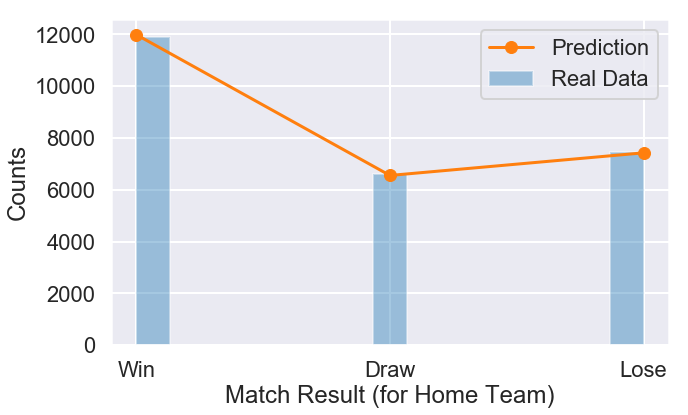

In [80]:
# Plot number of 3 match results against predicted number of 3 match results (home team win/draw/lose)

plt.figure(figsize=(10,6))
ax = sns.distplot(match_goal['result'],kde=False, label='Real Data')
plt.plot(np.arange(3), match_goal.shape[0]*np.array([p_win, p_draw, p_lose]), '-o', label="Prediction")
ax.set_xticks(np.arange(3))
ax.set_xticklabels(['Win', 'Draw', 'Lose'])
plt.xlabel('Match Result (for Home Team)')
plt.ylabel('Counts')
plt.legend()

预测的比例和实际比例非常接近。

#### 比分的分布

利用泊松分布模型和场均进球数还可以估计各种比分的出现比例（区分主客队，主队在前，客队在后。比如，1:0代表主队1:0客队，0:1代表主队0:1客队）。

In [83]:
# max goal for each team
max_goal = 4

# The row index is home team score, and the column index is away team score,
# the value is the probability for this match score
# define a matrix to store prediced probability for match scores
match_score_pred = np.zeros((max_goal+1,max_goal+1))

for i in np.arange(max_goal+1):
    for j in np.arange(max_goal+1):
        # Predict with poisson distribution
        match_score_pred[i,j] = poisson.pmf(np.arange(max_goal+1), lambda_home)[i]*poisson.pmf(np.arange(max_goal+1), lambda_away)[j]

# define a matrix to store actual percentage for match scores
match_score = np.zeros((max_goal+1, max_goal+1))

for i in np.arange(max_goal+1):
    for j in np.arange(max_goal+1):
        match_score[i,j] = match_goal[(match_goal['home_team_goal'] == i)&(match_goal['away_team_goal'] == j)].shape[0]/match_goal.shape[0]

In [89]:
print('比分预测')
print('比分 | 真实比例 | 估计比例')
for i in np.arange(max_goal+1):
    for j in np.arange(max_goal+1):
        print('{:1.0f}:{}{:9.2f}%{:9.2f}%'.format(i, j, match_score[i,j]*100, match_score_pred[i, j]*100))

比分预测
比分 | 真实比例 | 估计比例
0:0     7.61%     6.68%
0:1     7.17%     7.76%
0:2     4.64%     4.50%
0:3     2.06%     1.74%
0:4     0.85%     0.51%
1:0    10.17%    10.32%
1:1    11.60%    11.98%
1:2     6.39%     6.96%
1:3     2.85%     2.69%
1:4     0.95%     0.78%
2:0     8.21%     7.97%
2:1     8.39%     9.26%
2:2     5.04%     5.37%
2:3     1.88%     2.08%
2:4     0.64%     0.60%
3:0     4.34%     4.10%
3:1     4.64%     4.77%
3:2     2.36%     2.77%
3:3     1.02%     1.07%
3:4     0.19%     0.31%
4:0     2.07%     1.59%
4:1     1.84%     1.84%
4:2     0.94%     1.07%
4:3     0.33%     0.41%
4:4     0.10%     0.12%


估计的比例与实际比例非常接近。

#### 最常见的10种比分

In [95]:
# Top 10 popular match scores
n_top = 10

print('预计最常见的{}种比分'.format(n_top))
print('比分 | 估计比例')

for i in np.arange(n_top):
    home_index = np.argwhere(match_score_pred == np.partition(match_score_pred.flatten(), -i-1)[-i-1])[0][0]
    away_index = np.argwhere(match_score_pred == np.partition(match_score_pred.flatten(), -i-1)[-i-1])[0][1]
    print('{:1.0f}:{}{:9.2f}%'.format(home_index, away_index, np.partition(match_score_pred.flatten(), -i-1)[-i-1]*100))

print('\n实际最常见的{}种比分'.format(n_top))
print('比分 | 出现比例')
for i in np.arange(10):
    home_index = np.argwhere(match_score == np.partition(match_score.flatten(), -i-1)[-i-1])[0][0]
    away_index = np.argwhere(match_score == np.partition(match_score.flatten(), -i-1)[-i-1])[0][1]
    print('{:1.0f}:{}{:9.2f}%'.format(home_index, away_index, np.partition(match_score.flatten(), -i-1)[-i-1]*100))

预计最常见的10种比分
比分 | 估计比例
1:1    11.98%
1:0    10.32%
2:1     9.26%
2:0     7.97%
0:1     7.76%
1:2     6.96%
0:0     6.68%
2:2     5.37%
3:1     4.77%
0:2     4.50%

实际最常见的10种比分
比分 | 出现比例
1:1    11.60%
1:0    10.17%
2:1     8.39%
2:0     8.21%
0:0     7.61%
0:1     7.17%
1:2     6.39%
2:2     5.04%
3:1     4.64%
0:2     4.64%


在当前场均进球数的情况下，足球比赛最可能出现的比分是1:1，其次是1:0，然后是2:1和2:0。